# Setup

In [2]:
%pip install control

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import skfuzzy as fuzz

def gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u):
    # Gerando todas as combinações de entradas e calculando as saídas
    results = []
    for e_val in e.terms:
        row = []
        for delta_e_val in delta_e.terms:
            fuzzy_sim.input["e"] = e_val
            fuzzy_sim.input["delta_e"] = delta_e_val
            fuzzy_sim.compute()
            delta_u_val = fuzzy_sim.output["delta_u"]
            
            # Convertendo o valor de saída para o rótulo correspondente
            membership_values = {}
            for label in delta_u.terms:
                membership_values[label] = fuzz.interp_membership(
                    delta_u.universe, delta_u[label].mf, delta_u_val
                )
            label = max(membership_values, key=membership_values.get)
            row.append(label)
        results.append(row)

    # Criando um DataFrame com os resultados
    columns = delta_e.terms.keys()
    index = e.terms.keys()
    df = pd.DataFrame(results, columns=columns, index=index)

    # Adicionando a coluna de índice como "e[k] / Δe[k]"
    df.columns.name = "e[k] / Δe[k]"

    return df

In [4]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Definição dos parâmetros do motor
Pmec = 95 * 10**3
n = 0.913
Vn = 400
Wn = 1890 * pi / 30
Ra = 0.08
J = 0.56
La = 1.4 * 10**-3

Pele = Pmec / n
Cmn = Pmec / Wn
Ian = Pele / Vn
Kf = (Vn - Ian * Ra) / Wn
B = (Kf * Ian - Cmn) / Wn
Tm = J / B
Te = La / Ra
T = Te / 10

# Definição das matrizes A, B e C
A = np.array([[1 - T / Te, -Kf * T / La], [Kf * T / J, 1 - T / Tm]])
B = np.array([[T / La, 0], [0, -T / J]])


def simular_resposta_fuzzy(fuzzy_sim, setpoint, K, com_delta_e=True, plot=True):
    # Definição de parâmetros
    x = np.zeros((2, 1))
    u = np.zeros((2, 1))
    N = int(5 / T)

    W, Ia, t = [0] * (N + 1), [0] * (N + 1), np.linspace(0, 5, N + 1).tolist()
    errors, delta_errors, signals = [0] * (N + 1), [0] * (N + 1), [0] * (N + 1)

    Kp, Ki = K

    for i in range(N):
        # Cálculo do erro
        curr_error = (setpoint - W[i]) / setpoint * 100
        errors[i] = curr_error

        # Entrada do controlador fuzzy
        fuzzy_sim.input["e"] = curr_error * Ki

        if com_delta_e:
            delta_errors[i] = errors[i - 1] - curr_error if i > 0 else 0
            fuzzy_sim.input["delta_e"] = delta_errors[i] * Kp

        # Processa controle fuzzy
        fuzzy_sim.compute()

        # Sinal de controle
        control_signal_current = min(400, signals[i] + fuzzy_sim.output["delta_u"])
        signals[i + 1] = control_signal_current

        # Atualiza entrada do sistema
        u[0, 0] = control_signal_current

        # Cálculo da saída
        x = A @ x + B @ u
        Ia[i + 1], W[i + 1] = x.flatten()

    if plot == False:
        return W, t, signals, errors

    # Mostrando os gráficos de velocidade, corrente, erros e sinais em uma matriz 2x2
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

    # Gráfico de Velocidade
    ax1.axhline(setpoint, color="b", linestyle="--", label="Setpoint")
    ax1.plot(t, W, color="r")
    ax1.set_title("Velocidade do eixo")
    ax1.set_xlabel("Tempo (s)")
    ax1.set_ylabel("Velocidade (rad/s)")
    ax1.set_yticks(np.arange(min(W), max(W) + 20, 15))
    ax1.tick_params(axis="y", labelsize=8)
    ax1.legend(["Velocidade"])

    # Gráfico de Sinais de Controle
    ax2.plot(t, signals, color="m")
    ax2.set_title("Sinais de Controle")
    ax2.set_xlabel("Tempo (s)")
    ax2.set_ylabel("Sinal de Controle")
    ax2.legend(["Sinal de Controle"])

    # Gráfico de Erros
    ax3.plot(t, errors, color="g")
    ax3.set_title("Erros")
    ax3.set_xlabel("Tempo (s)")
    ax3.set_ylabel("Erro")
    ax3.legend(["Erro"])

    # Gráfico de Delta Erros
    if not com_delta_e:
        delta_errors = np.zeros_like(t)
    ax4.plot(t, delta_errors, color="c")
    ax4.set_title("Delta Erros")
    ax4.set_xlabel("Tempo (s)")
    ax4.set_ylabel("Delta Erro")
    ax4.legend(["Delta Erro"])

    plt.tight_layout()
    plt.show()

    return W, t, signals, errors

# Controle PI tradicional

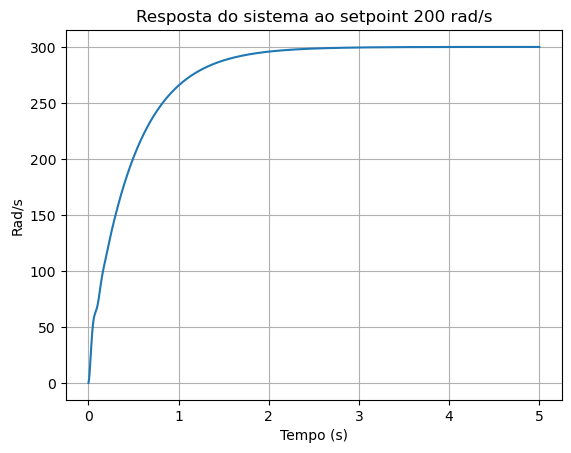

In [5]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling time
T = 0.00175

# Define the transfer functions
num_gpz = [0.0058540, 0, 0]
den_gpz = [1, -1.9224928, 0.9337476]

gpz = ct.TransferFunction(num_gpz, den_gpz, T)
gpi = 0.15 * ct.TransferFunction([1, -0.95], [1, -1], T)
# gpid = 1 * ctrl.TransferFunction([1, -0.2], [1, -0.1], T)

# Compute the closed-loop transfer function
sys_open_loop = ct.series(gpz, gpi)  # C(s) * G(s)
sys_closed_loop = ct.feedback(sys_open_loop, 1)

# Root locus plot
# Simulate system response to a 400V input and 0 load
time = np.arange(0, 5, T)
T_out, yout = ct.forced_response(sys_closed_loop, T=time, U=np.ones_like(time)*300)

# Plot the response
plt.figure()
plt.plot(T_out, yout)
plt.xlabel('Tempo (s)')
plt.ylabel('Rad/s')
plt.title('Resposta do sistema ao setpoint 200 rad/s')
plt.grid()
plt.show()

# Controle PI Fuzzy

c:\Users\ALUNO\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


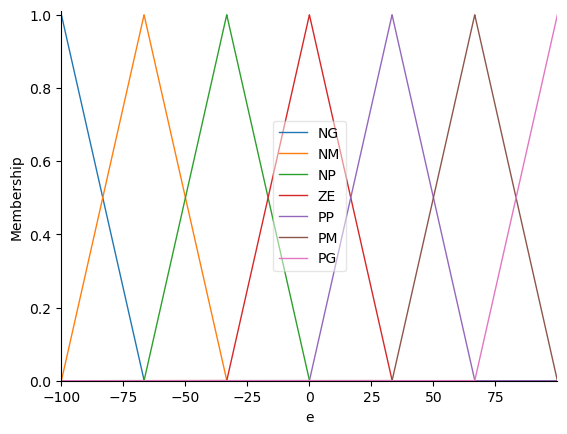

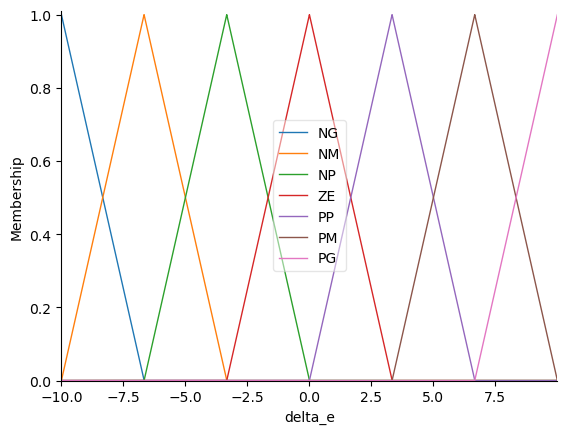

In [6]:
import numpy as np
from skfuzzy import control as ctrl

# Definindo as variáveis fuzzy
e = ctrl.Antecedent(np.arange(-100, 100, 0.005), "e")
delta_e = ctrl.Antecedent(np.arange(-10, 10, 0.001), "delta_e")
delta_u = ctrl.Consequent(np.arange(-10, 10, 0.001), "delta_u")

# Definindo as funções de pertinência

CODIGOS = ["NG", "NM", "NP", "ZE", "PP", "PM", "PG"]

e.automf(names=CODIGOS)
delta_e.automf(names=CODIGOS)
delta_u.automf(names=CODIGOS)

# Criando as regras fuzzy
rules_1 = [
    ctrl.Rule(e["NG"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["NP"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["ZE"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["PP"], delta_u["NM"]),
    ctrl.Rule(e["NG"] & delta_e["PM"], delta_u["NP"]),
    ctrl.Rule(e["NG"] & delta_e["PG"], delta_u["ZE"]),
    ctrl.Rule(e["NM"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["NP"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["ZE"], delta_u["NM"]),
    ctrl.Rule(e["NM"] & delta_e["PP"], delta_u["NP"]),
    ctrl.Rule(e["NM"] & delta_e["PM"], delta_u["ZE"]),
    ctrl.Rule(e["NM"] & delta_e["PG"], delta_u["PP"]),
    ctrl.Rule(e["NP"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NP"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NP"] & delta_e["NP"], delta_u["NM"]),
    ctrl.Rule(e["NP"] & delta_e["ZE"], delta_u["NP"]),
    ctrl.Rule(e["NP"] & delta_e["PP"], delta_u["ZE"]),
    ctrl.Rule(e["NP"] & delta_e["PM"], delta_u["PP"]),
    ctrl.Rule(e["NP"] & delta_e["PG"], delta_u["PM"]),
    ctrl.Rule(e["ZE"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["ZE"] & delta_e["NM"], delta_u["NM"]),
    ctrl.Rule(e["ZE"] & delta_e["NP"], delta_u["NP"]),
    ctrl.Rule(e["ZE"] & delta_e["ZE"], delta_u["ZE"]),
    ctrl.Rule(e["ZE"] & delta_e["PP"], delta_u["PP"]),
    ctrl.Rule(e["ZE"] & delta_e["PM"], delta_u["PM"]),
    ctrl.Rule(e["ZE"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PP"] & delta_e["NG"], delta_u["NM"]),
    ctrl.Rule(e["PP"] & delta_e["NM"], delta_u["NP"]),
    ctrl.Rule(e["PP"] & delta_e["NP"], delta_u["ZE"]),
    ctrl.Rule(e["PP"] & delta_e["ZE"], delta_u["PP"]),
    ctrl.Rule(e["PP"] & delta_e["PP"], delta_u["PM"]),
    ctrl.Rule(e["PP"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PP"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["NG"], delta_u["NP"]),
    ctrl.Rule(e["PM"] & delta_e["NM"], delta_u["ZE"]),
    ctrl.Rule(e["PM"] & delta_e["NP"], delta_u["PP"]),
    ctrl.Rule(e["PM"] & delta_e["ZE"], delta_u["PM"]),
    ctrl.Rule(e["PM"] & delta_e["PP"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["NG"], delta_u["ZE"]),
    ctrl.Rule(e["PG"] & delta_e["NM"], delta_u["PP"]),
    ctrl.Rule(e["PG"] & delta_e["NP"], delta_u["PM"]),
    ctrl.Rule(e["PG"] & delta_e["ZE"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PP"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PG"], delta_u["PG"]),
]

# Criando o sistema de controle
control_system = ctrl.ControlSystem(rules_1)

# Simulando o sistema
fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u)

e.view()
delta_e.view()

In [7]:
W, t, signals, errors = simular_resposta_fuzzy(fuzzy_sim, 100, [0.2, 0.1])

KeyboardInterrupt: 

# Teste

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

def generate_race_track():
    # Define key control points for the track (mix of curves and straights)
    control_points = np.array([
        [0, 0], [2, 1], [4, 1],  # First straight
        [6, 2], [7, 5], [6, 6],  # First curve
        [4, 7], [2, 7], [0, 6],  # Second straight
        [-2, 5], [-4, 4], [-2, 1],  # Second curve
        [0, 0]  # Close the loop
    ]).T * 2  # Transpose for compatibility

    # Generate a smooth spline curve through control points
    tck, u = splprep(control_points, s=0, per=True)  # Closed curve
    u_fine = np.linspace(0, 1, 500)  # Increased number of points for smoothness
    smooth_track = splev(u_fine, tck)
    
    return smooth_track[:2]


def generate_road_limits(race_track, width=0.5):
    """
    Gera os limites interno e externo da estrada com largura constante.
    """
    x, y = race_track

    # Calcular a direção tangente à pista
    dx = np.gradient(x)
    dy = np.gradient(y)
    
    # Calcular a direção perpendicular (vetor normal)
    norm = np.sqrt(dx**2 + dy**2)
    nx = -dy / norm
    ny = dx / norm
    
    # Calcular os limites interno e externo
    x_inner = x - nx * width / 2
    y_inner = y - ny * width / 2
    x_outer = x + nx * width / 2
    y_outer = y + ny * width / 2
    
    return np.column_stack((x_inner, y_inner, x_outer, y_outer))

# Gerar os pontos suavizados da pista
race_track = generate_race_track()

# Gerar os limites da estrada com largura constante de 20 metros
limits = generate_road_limits(race_track, width=1)

In [31]:
class FuzzyCar:
    def __init__(self, width, length, max_speed=80, initial_angle=90):
        self.width = width
        self.length = length
        self.max_speed = max_speed
        self.curr_speed = 2
        self.current_pos = (0, 0)
        self.velocity = (0, initial_angle)

        proximity = ctrl.Antecedent(
            np.arange(-0.1, 0.11, 0.01),
            "limit_dist_diff",
        )

        max_radian = 10 * np.pi / 180
        angle = ctrl.Consequent(np.arange(-max_radian, max_radian + 0.1, 0.1), "angle")

        # Positivo: margem direita mais próxima
        proximity.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])

        # Positivo: sentido anti-horário
        angle.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])

        rules = [
            ctrl.Rule(proximity["NG"], angle["NG"]),
            ctrl.Rule(proximity["NM"], angle["NM"]),
            ctrl.Rule(proximity["NP"], angle["NP"]),
            ctrl.Rule(proximity["ZE"], angle["ZE"]),
            ctrl.Rule(proximity["PP"], angle["PP"]),
            ctrl.Rule(proximity["PM"], angle["PM"]),
            ctrl.Rule(proximity["PG"], angle["PG"]),
        ]

        # Criando o sistema de controle e simulacao
        control_system = ctrl.ControlSystem(rules)
        self.fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

    def nearest_limit_points_diff(self, limits):
        inner_dists = np.sum(np.square(limits[:, :2] - self.current_pos), axis=1)
        outer_dists = np.sum(np.square(limits[:, 2:] - self.current_pos), axis=1)
        return min(outer_dists) - min(inner_dists)

    def update_position(self, limits):
        self.fuzzy_sim.input["limit_dist_diff"] = self.nearest_limit_points_diff(limits)

        self.fuzzy_sim.compute()
        angle = self.fuzzy_sim.output["angle"]

        self.velocity = np.array([self.curr_speed, angle])
        self.current_pos += self.curr_speed * np.array([np.sin(angle), np.cos(angle)])
        
        return self.current_pos + self.curr_speed * np.array([np.sin(angle), np.cos(angle)])




TypeError: list indices must be integers or slices, not tuple

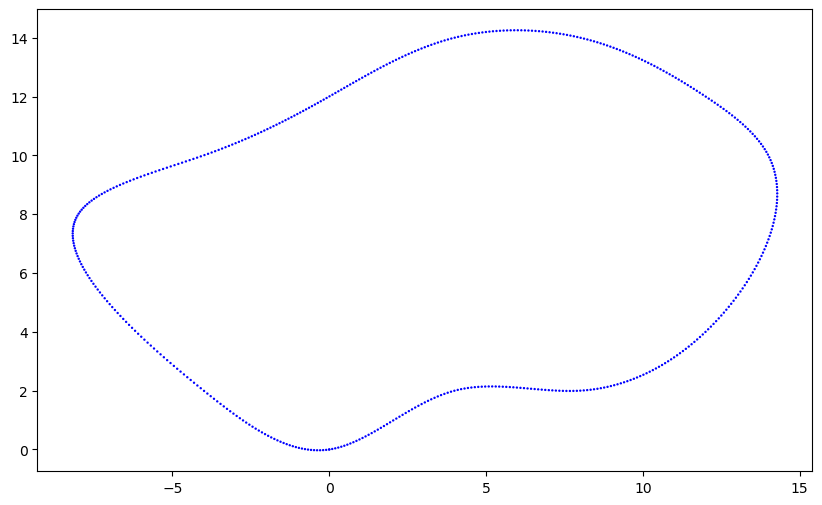

In [ ]:
# car_path = [car.update_position(limits) for _ in range(len(race_track[0]))]
car = FuzzyCar(2, 4)
car_path = []

for waypoint in range(len(race_track[0])):
    pos = car.update_position(limits)
    car_path.append(pos)
    
    
# Plotar a pista e os limites da estrada
plt.figure(figsize=(10, 6))
plt.scatter(race_track[0], race_track[1], label="Centro da Pista", color="blue", linestyle="--", s=0.5)
plt.scatter(car_path[0], car_path[1], label="Caminho do carro", color="blue", linestyle="--", s=0.5)
plt.plot(limits[:,0], limits[:,1], label="Limite Interno", color="green")
plt.plot(limits[:,2], limits[:,3], label="Limite Externo", color="green")
plt.title("Pista de Corrida com Largura Constante de 20 Metros")
plt.xlabel("X (metros)")
plt.ylabel("Y (metros)")
plt.axis("equal")
plt.legend()
plt.show()